## Download dataset and import library

In [ ]:
!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 105MB/s]


In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contractions

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Read dataset and define necessary library

In [ ]:
df= pd.read_csv('./IMDB-Dataset.csv')
# Remove duplicate rows
df = df.drop_duplicates()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
  return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
  wl = WordNetLemmatizer()

  soup = BeautifulSoup(text, "html.parser")  # Removing HTML tags

  text = soup.get_text()
  text = expand_contractions(text)  # Expanding contractions

  emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

  text = emoji_clean.sub(r'', text)

  text = re.sub(r'\.(?=\S)', '. ', text)  # Add space after full stop
  text = re.sub(r'http\S+', '', text)  # Remove URLs
  text = "".join([word.lower() for word in text if word not in string.punctuation])  # Remove punctuation and make text lowercase
  text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])  # Lemmatize

  return text

df['review'] = df['review'].apply(preprocess_text)
df.head()

<ipython-input-5-2d875abd8a1c>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")  # Removing HTML tags


,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


## Analysis data

<function matplotlib.pyplot.show(close=None, block=None)>

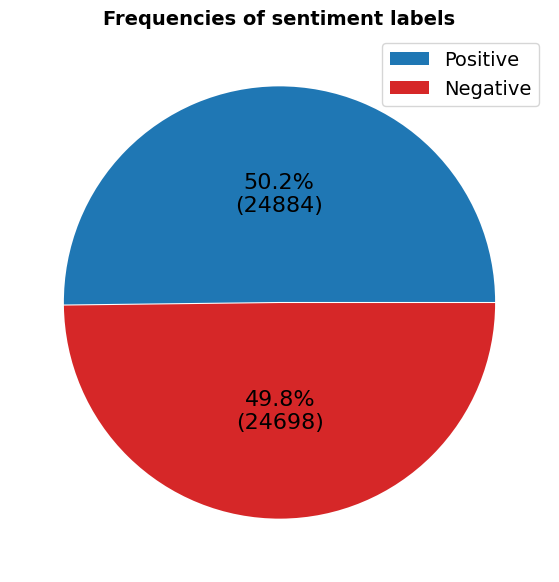

In [ ]:
# Create autocpt agruments
def func(pct, allvalues):
  absolute = int(pct / 100.*np.sum(allvalues))
  return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment']=='positive'])
freq_neg = len(df[df['sentiment']=='negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize':16})

plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc='best', prop={'size':14})
pie.savefig('PieChart.png')
plt.show

In [ ]:
print(f'Number of positive reviews: {freq_pos}')
print(f'Number of negative reviews: {freq_neg}')

Number of positive reviews: 24884
Number of negative reviews: 24698


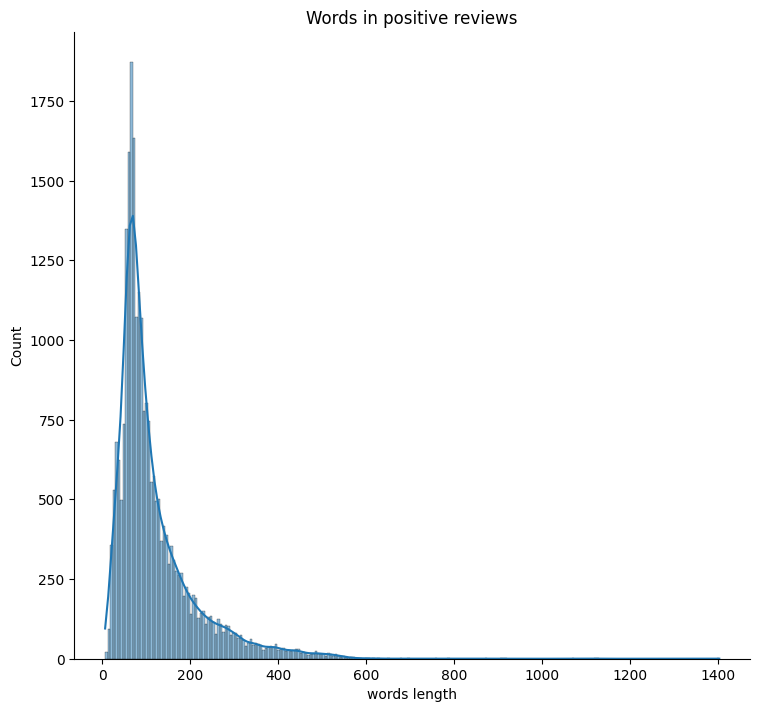

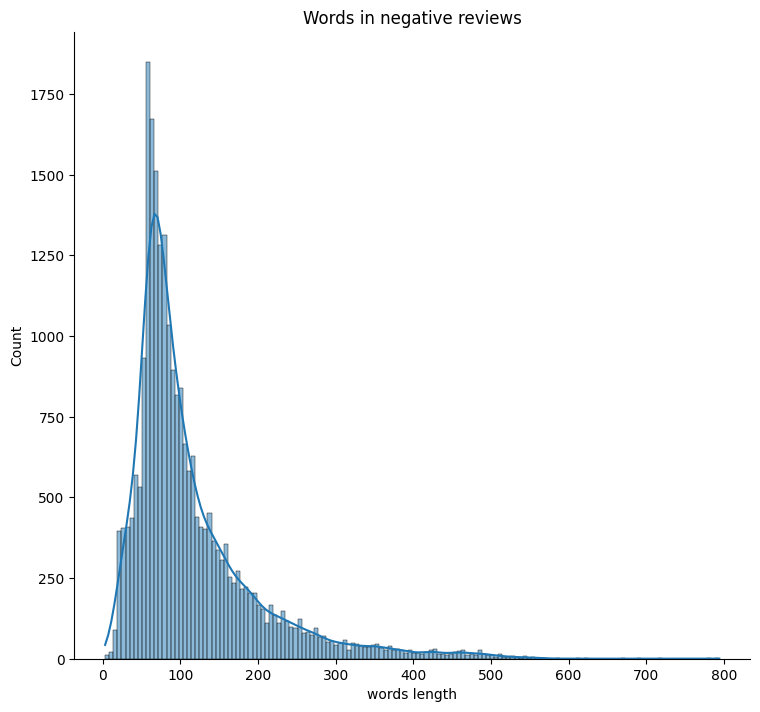

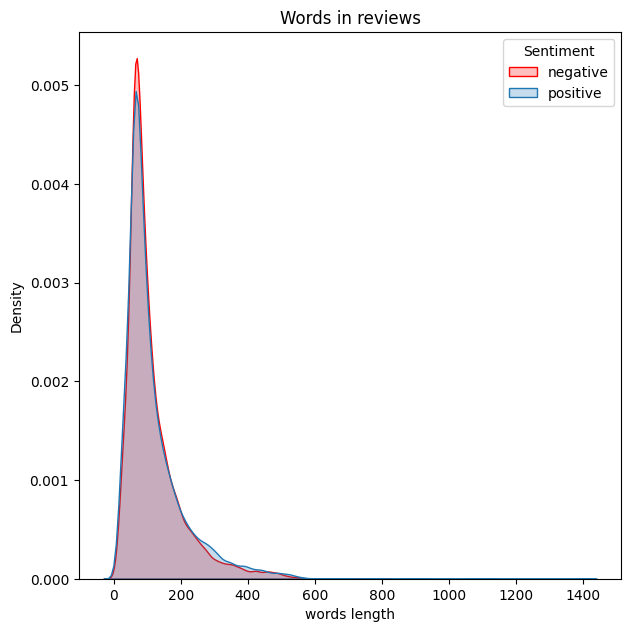

In [ ]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7,7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x='words length', hue='sentiment', fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])

plt.show(kernel_distribution_number_words_plot)

## Train the model

### Split train and test dataset

In [ ]:
label_encoder = LabelEncoder()

x_data = label_encoder.fit_transform(df['review'])
y_data =  label_encoder.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

### Vectorize data

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(df['review'])

x_train_encoded = tfidf_vectorizer.transform(df['review'].iloc[x_train])
y_train_encoded = tfidf_vectorizer.transform(df['review'].iloc[y_train])
x_test_encoded = tfidf_vectorizer.transform(df['review'].iloc[x_test])
y_test_encoded = tfidf_vectorizer.transform(df['review'].iloc[y_test])

### Train and evaluate model

In [ ]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_of_dt = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy_of_dt}')

Accuracy: 0.4977311687002118


In [ ]:
rf_classifier = RandomForestClassifier(
    random_state=42,
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_of_rf = accuracy_score(y_pred, y_test)
print(f'Accuracy: {accuracy_of_rf}')

Accuracy: 0.5007562770999294
